In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

data = pd.read_csv(r'C:\Users\Wiktoria\Documents\PM\BTC-USD(1).csv')


data['Volume'] = data['Volume'].astype(str).str.replace(',', '').replace('-', '0').astype(float)

for col in ['Open', 'High', 'Low', 'Close']:
    data[col] = pd.to_numeric(data[col], errors='coerce')

data.dropna(inplace=True)

features = ['Open', 'High', 'Low', 'Close', 'Volume']
data = data[features]

In [14]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)
scaled_data = scaled_data[1000:]

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length, 3])  # Predicting 'Close' price
    return np.array(X), np.array(y)

SEQ_LENGTH = 60
X, y = create_sequences(scaled_data, SEQ_LENGTH)

X = X.reshape((X.shape[0], X.shape[1], len(features)))

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [15]:
#jak wielka sekwencja
print("X shape:", X.shape)  # (liczba próbek, długość sekwencji, liczba cech)
print("y shape:", y.shape)  # (liczba próbek,)

X shape: (1687, 60, 5)
y shape: (1687,)


In [16]:
import tensorflow as tf
from tensorflow.keras.layers import GRU, Dense, Dropout, Input, Bidirectional
from tensorflow.keras.models import Model

# Funkcja tworząca model
def create_model(input_shape, 
                 units=50, 
                 is_bidirectional=False,
                 is_dense=False,
                 rnn_type='GRU', 
                 dropout_rate=0.2):
    
    # Warstwa wejściowa
    inputs = Input(shape=input_shape)

    # Warstwa RNN (GRU lub LSTM)
    if rnn_type == 'GRU':
        rnn_out = GRU(units, return_sequences=True)(inputs)
    elif rnn_type == 'LSTM':
        rnn_out = LSTM(units, return_sequences=True)(inputs)
    else:
        raise ValueError("rnn_type musi być 'GRU' lub 'LSTM'")
    dropout1 = Dropout(dropout_rate)(rnn_out)

    # Druga warstwa RNN
    if rnn_type == 'GRU':
        rnn_out2 = GRU(units, return_sequences=is_bidirectional)(dropout1)
    elif rnn_type == 'LSTM':
        rnn_out2 = LSTM(units, return_sequences=is_bidirectional)(dropout1)

    #Dodanie wartstwy Bidirectional 
    if is_bidirectional:
        bidirectional=Bidirectional(LSTM(units=50))(rnn_out2)
        dropout2 = Dropout(dropout_rate)(bidirectional)
    else:
        dropout2 = Dropout(dropout_rate)(rnn_out2)
    
    #Dodanie warstwy Dense
    if is_dense:
        dense1=Dense(units=30, activation="relu")(dropout2)
        dropout2 = dense1
    
    # Wyjście (jedna jednostka, bez aktywacji do przewidywania wartości ciągłej)
    outputs = Dense(1)(dropout2)

    # Tworzenie modelu
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='mean_absolute_percentage_error')

    return model


In [17]:
# Funkcja do prognozowania w interwałach
def predict_in_intervals(model, X_test, interval_size=1000):
    predictions = []
    for start in range(0, len(X_test), interval_size):
        end = min(start + interval_size, len(X_test))
        predictions_interval = model.predict(X_test[start:end])
        predictions.append(predictions_interval)
    return np.concatenate(predictions)

In [18]:

input_shape = (X_train.shape[1], len(features))  # dopasowujemy do danych
#Model LSTM, units 50, dropout 0.3
model_lstm_1 = create_model(input_shape=input_shape, 
                                   units=50,
                                   rnn_type='LSTM', 
                                   dropout_rate=0.3)

#Model LSTM, units 100, dropout 0.3
model_lstm_2 = create_model(input_shape=input_shape, 
                                       units=100,  
                                       rnn_type='LSTM', 
                                       dropout_rate=0.3)

#Model LSTM, units 100, dropout 0.6
input_shape = (X_train.shape[1], len(features))  # dopasowujemy do danych
model_lstm_3 = create_model(input_shape=input_shape, 
                                   units=100,
                                   rnn_type='LSTM', 
                                   dropout_rate=0.6)

#Model LSTM z wartwa bidirectional, units 50, dropout 0.3
model_lstm_1_bidirectional = create_model(input_shape=input_shape, 
                                   units=50, is_bidirectional=True,
                                   rnn_type='LSTM', 
                                   dropout_rate=0.3)

#Model LSTM z wartwa bidirectional, units 100, dropout 0.3
model_lstm_2_bidirectional = create_model(input_shape=input_shape, 
                                       units=100, is_bidirectional=True, 
                                       rnn_type='LSTM', 
                                       dropout_rate=0.3)

#Model LSTM z wartwa bidirectional, units 100, dropout 0.6
input_shape = (X_train.shape[1], len(features))  # dopasowujemy do danych
model_lstm_3_bidirectional = create_model(input_shape=input_shape, 
                                   units=100, is_bidirectional=True,
                                   rnn_type='LSTM', 
                                   dropout_rate=0.6)

#Model LSTM z wartwa dense, units 50, dropout 0.3
model_lstm_1_dense = create_model(input_shape=input_shape, 
                                   units=50, is_dense=True,
                                   rnn_type='LSTM', 
                                   dropout_rate=0.3)

#Model LSTM z wartwa dense, units 100, dropout 0.3
model_lstm_2_dense = create_model(input_shape=input_shape, 
                                       units=100, is_dense=True,
                                       rnn_type='LSTM', 
                                       dropout_rate=0.3)

#Model LSTM z wartwa dense, units 100, dropout 0.6
input_shape = (X_train.shape[1], len(features))  # dopasowujemy do danych
model_lstm_3_dense = create_model(input_shape=input_shape, 
                                   units=100, is_dense=True,
                                   rnn_type='LSTM', 
                                   dropout_rate=0.6)

In [19]:
history1 = model_lstm_1.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - loss: 40.7518 - val_loss: 15.3027
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 13.5827 - val_loss: 6.6710
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 12.0482 - val_loss: 6.1486
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 11.0114 - val_loss: 9.1508
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 10.9217 - val_loss: 6.5197
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 11.7509 - val_loss: 6.4536
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 9.7743 - val_loss: 5.2714
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 9.8834 - val_loss: 7.4270
Epoch 9/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 10.6682 - val_loss: 5.1776
Epoch 10/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 8.1731 - val_loss: 5.3470
Epoch 11/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 8.0521 - val_loss: 5.0758
Epoch 12/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - l

In [20]:
history2 = model_lstm_2.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - loss: 27.8628 - val_loss: 6.3351
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 10.5207 - val_loss: 6.5751
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - loss: 10.1594 - val_loss: 6.1877
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 10.4887 - val_loss: 8.7944
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 9.2138 - val_loss: 5.8467
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 10.8022 - val_loss: 5.7566
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 8.5763 - val_loss: 5.1599
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 8.3540 - val_loss: 4.8317
Epoch 9/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 7.7993 - val_loss: 5.8351
Epoch 10/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 8.9306 - val_loss: 4.8213
Epoch 11/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 7.9572 - val_loss: 4.7042
Epoch 12/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss

In [21]:
history3 = model_lstm_3.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - loss: 33.5962 - val_loss: 6.3707
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 16.5416 - val_loss: 6.0055
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 14.0623 - val_loss: 6.4087
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 12.8541 - val_loss: 5.7695
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 13.3742 - val_loss: 5.5410
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 12.3883 - val_loss: 6.6482
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 11.0776 - val_loss: 10.5428
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 11.9103 - val_loss: 5.5351
Epoch 9/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 11.0085 - val_loss: 5.5584
Epoch 10/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 10.1503 - val_loss: 7.2571
Epoch 11/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 10.4139 - val_loss: 7.5715
Epoch 12/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step

In [22]:
history4 = model_lstm_1_bidirectional.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - loss: 37.6148 - val_loss: 22.1000
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 13.1163 - val_loss: 10.6184
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 11.9597 - val_loss: 10.8966
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 11.2746 - val_loss: 7.0276
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 11.6280 - val_loss: 12.0608
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 11.1223 - val_loss: 10.8437
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 10.4882 - val_loss: 16.1962
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 10.5424 - val_loss: 6.8017
Epoch 9/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 10.2823 - val_loss: 9.9975
Epoch 10/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 9.3912 - val_loss: 7.6102
Epoch 11/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 10.4059 - val_loss: 8.0157
Epoch 12/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/

In [23]:
history5 = model_lstm_2_bidirectional.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 11s 98ms/step - loss: 32.4046 - val_loss: 16.9262
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - loss: 13.3822 - val_loss: 9.6121
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - loss: 12.7709 - val_loss: 16.1551
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - loss: 11.9955 - val_loss: 6.4896
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - loss: 10.8949 - val_loss: 6.4756
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - loss: 10.9537 - val_loss: 6.1167
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - loss: 10.1115 - val_loss: 6.1381
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - loss: 10.0277 - val_loss: 6.0241
Epoch 9/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - loss: 9.4708 - val_loss: 7.9407
Epoch 10/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - loss: 9.1967 - val_loss: 10.3541
Epoch 11/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - loss: 9.2692 - val_loss: 5.3902
Epoch 12/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step

In [24]:
history6 = model_lstm_3_bidirectional.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 11s 96ms/step - loss: 36.1956 - val_loss: 9.3748
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - loss: 18.3107 - val_loss: 8.1603
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - loss: 18.9445 - val_loss: 9.3332
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - loss: 16.1725 - val_loss: 8.7420
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - loss: 15.3829 - val_loss: 8.2117
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - loss: 14.1156 - val_loss: 8.3299
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - loss: 13.5181 - val_loss: 8.9030
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - loss: 12.5690 - val_loss: 20.2304
Epoch 9/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - loss: 14.9361 - val_loss: 8.9672
Epoch 10/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - loss: 11.7884 - val_loss: 7.0281
Epoch 11/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - loss: 12.1396 - val_loss: 7.1143
Epoch 12/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/ste

In [25]:
history7 = model_lstm_1_dense.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - loss: 31.9154 - val_loss: 9.2129
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 12.5700 - val_loss: 6.8534
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 11.3036 - val_loss: 6.3641
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 10.5079 - val_loss: 8.4754
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 9.3087 - val_loss: 7.2889
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 8.3616 - val_loss: 5.9771
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 8.3883 - val_loss: 5.5765
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 9.2513 - val_loss: 10.6494
Epoch 9/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 8.5813 - val_loss: 5.4234
Epoch 10/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 8.6209 - val_loss: 9.5525
Epoch 11/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 7.8455 - val_loss: 9.1231
Epoch 12/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss

In [58]:
history8 = model_lstm_2_dense.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - loss: 36.2896 - val_loss: 6.4560
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 10.5889 - val_loss: 12.8454
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 11.2253 - val_loss: 8.0387
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 9.2397 - val_loss: 6.0185
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 9.8169 - val_loss: 5.3014
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 7.5689 - val_loss: 5.3456
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 7.8375 - val_loss: 5.0933
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 7.1456 - val_loss: 5.0779
Epoch 9/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 7.3721 - val_loss: 5.3584
Epoch 10/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 7.1961 - val_loss: 4.8485
Epoch 11/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 7.1548 - val_loss: 7.2305
Epoch 12/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss:

In [59]:
history9 = model_lstm_3_dense.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 6.4555 - val_loss: 4.3768
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 6.4768 - val_loss: 7.6129
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 7.0273 - val_loss: 13.3828
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 6.6819 - val_loss: 12.2857
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 6.5693 - val_loss: 15.2213
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 6.8615 - val_loss: 9.3523
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 6.3918 - val_loss: 5.3875
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 6.2618 - val_loss: 12.8403
Epoch 9/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 6.7129 - val_loss: 10.8105
Epoch 10/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 6.3286 - val_loss: 4.2228
Epoch 11/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 6.2510 - val_loss: 5.3854
Epoch 12/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss

In [28]:
import matplotlib.pyplot as plt

def plot_validation_loss(history, figsize=(14, 8), title='Model Validation Loss Over Epochs'):
    plt.figure(figsize=figsize)
    plt.plot(history.history['val_loss'], color='darkred', linestyle='-', linewidth=1.5, label='Validation Loss')
    plt.title(title, fontsize=18, fontweight='bold')
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Validation Loss (Mean Absolute Percentage Error)', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.show()

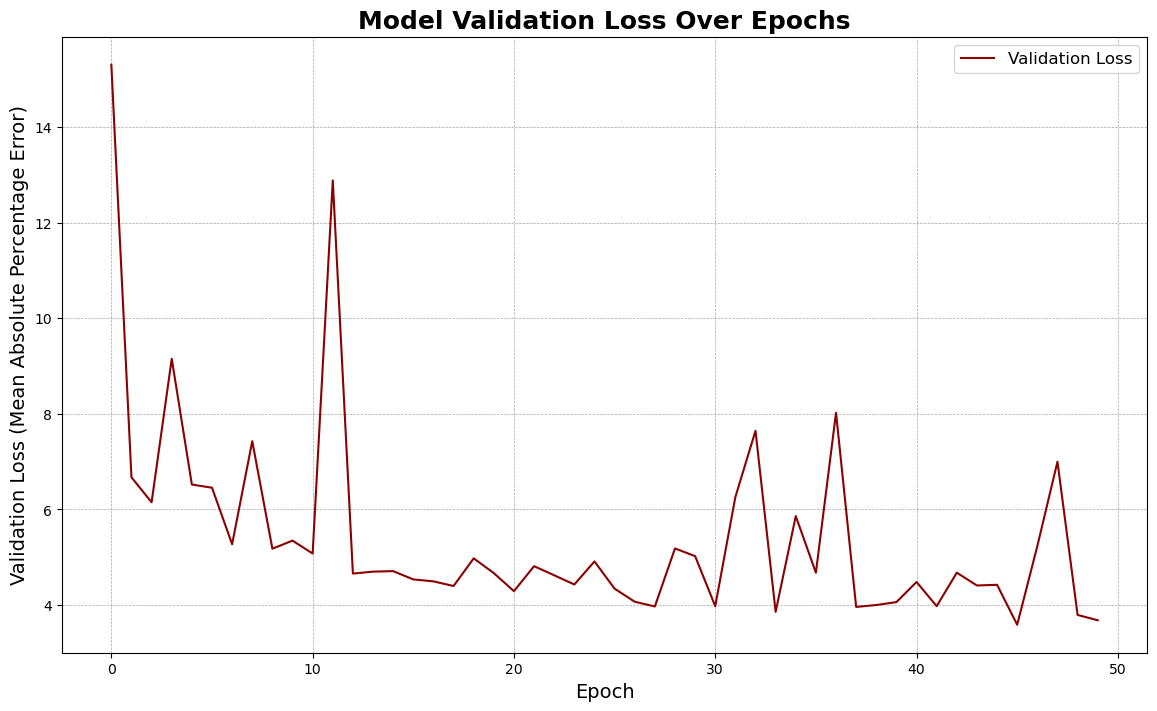

In [29]:
plot_validation_loss(history1)

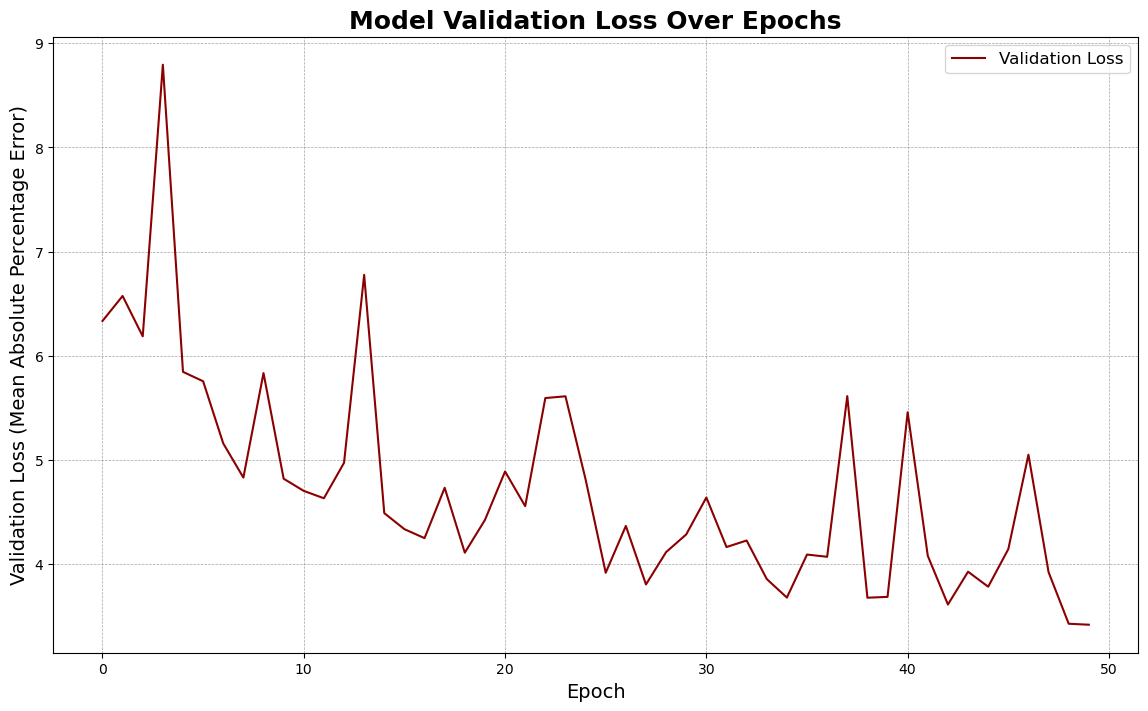

In [30]:
plot_validation_loss(history2)

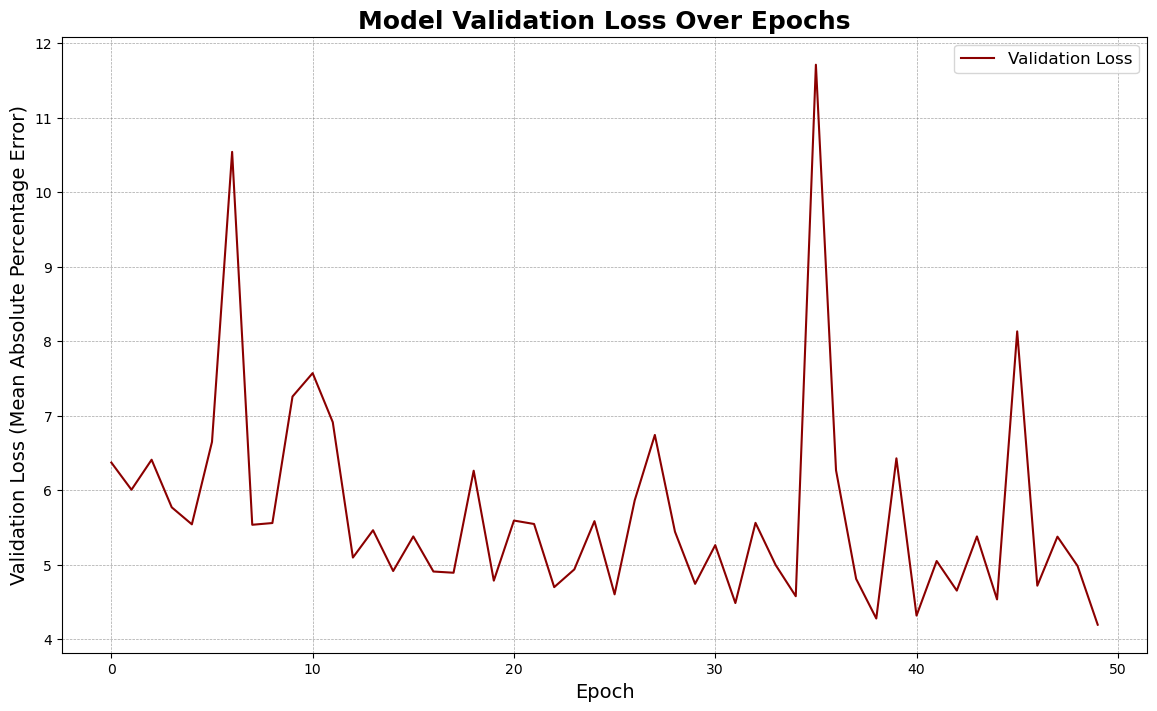

In [31]:
plot_validation_loss(history3)

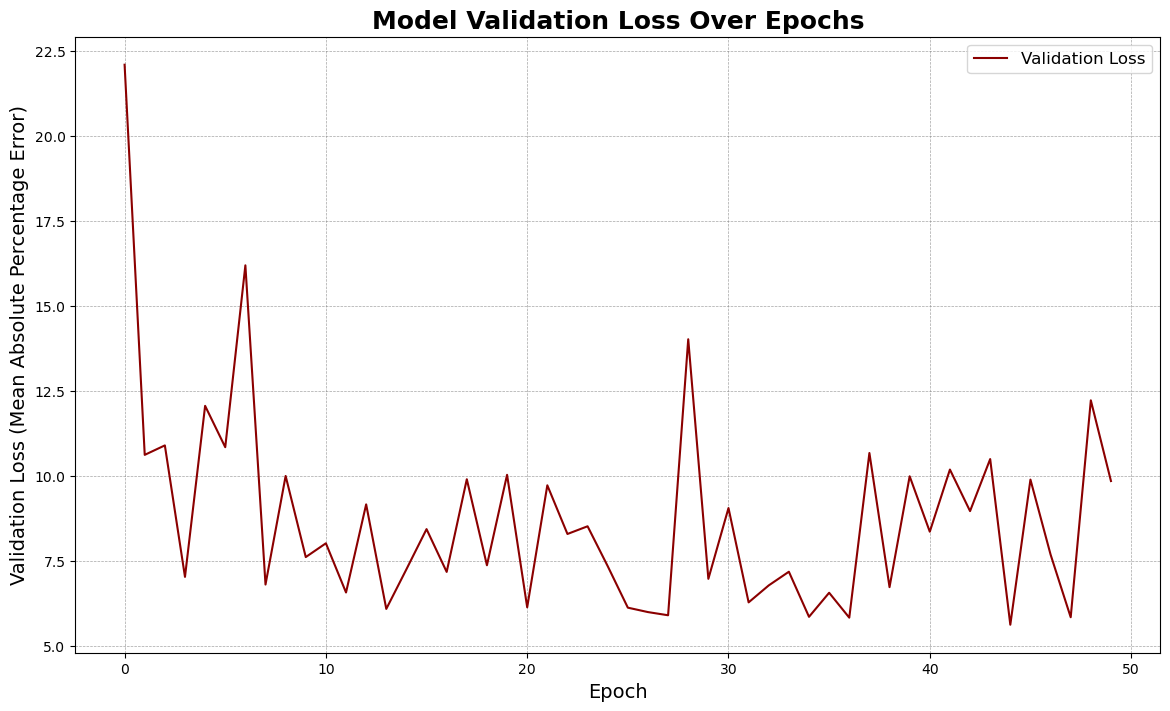

In [32]:
plot_validation_loss(history4)

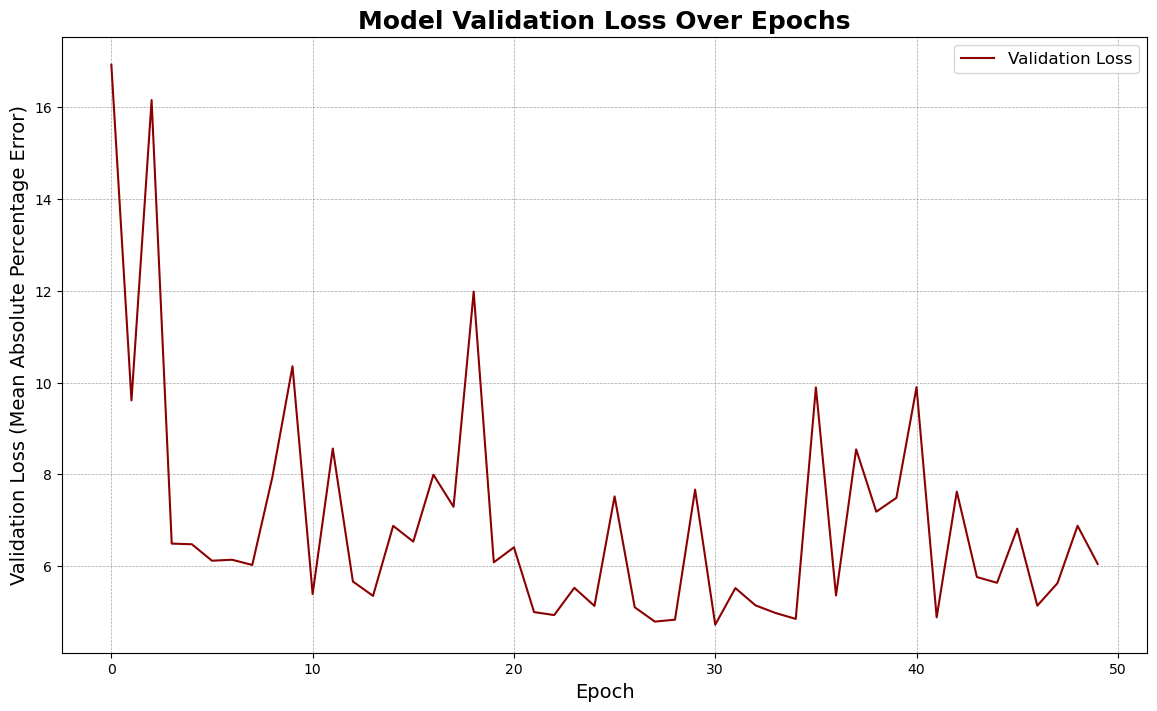

In [33]:
plot_validation_loss(history5)

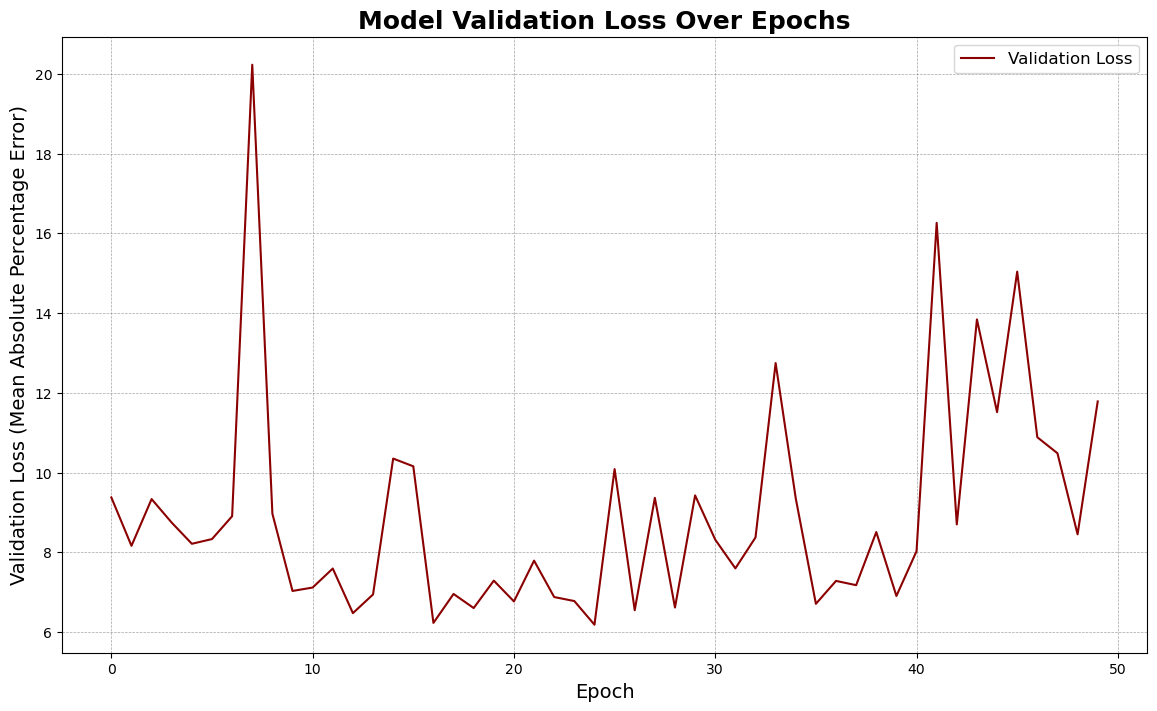

In [34]:
plot_validation_loss(history6)

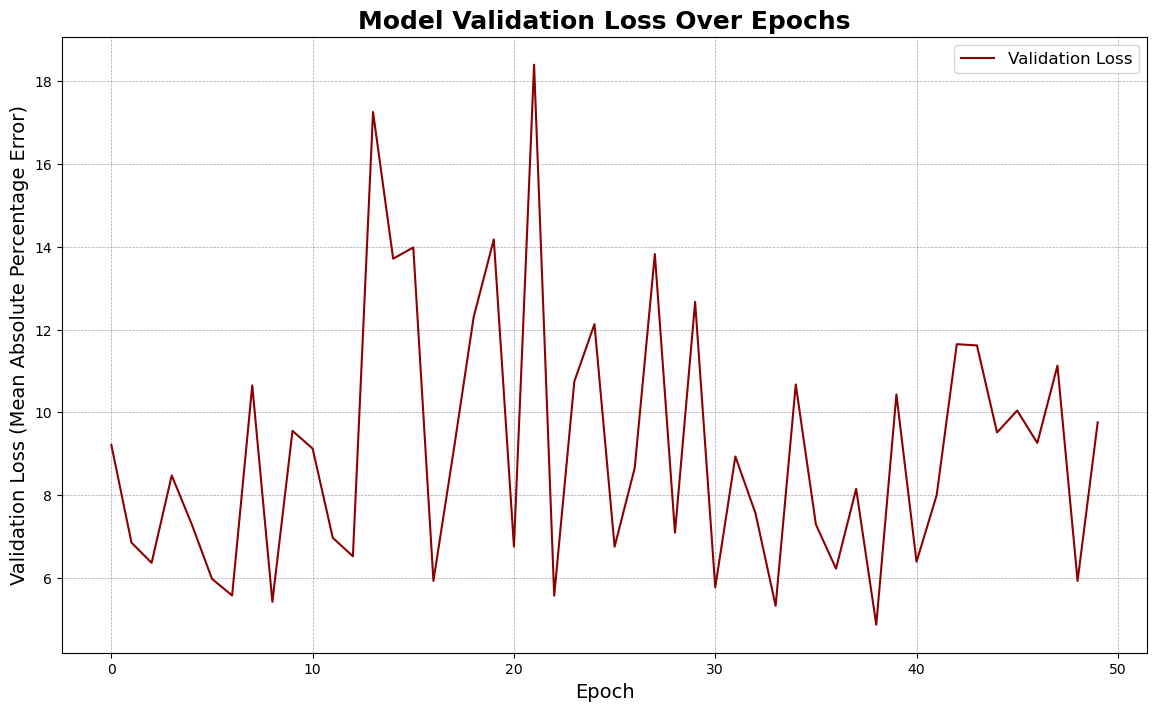

In [66]:
plot_validation_loss(history7)

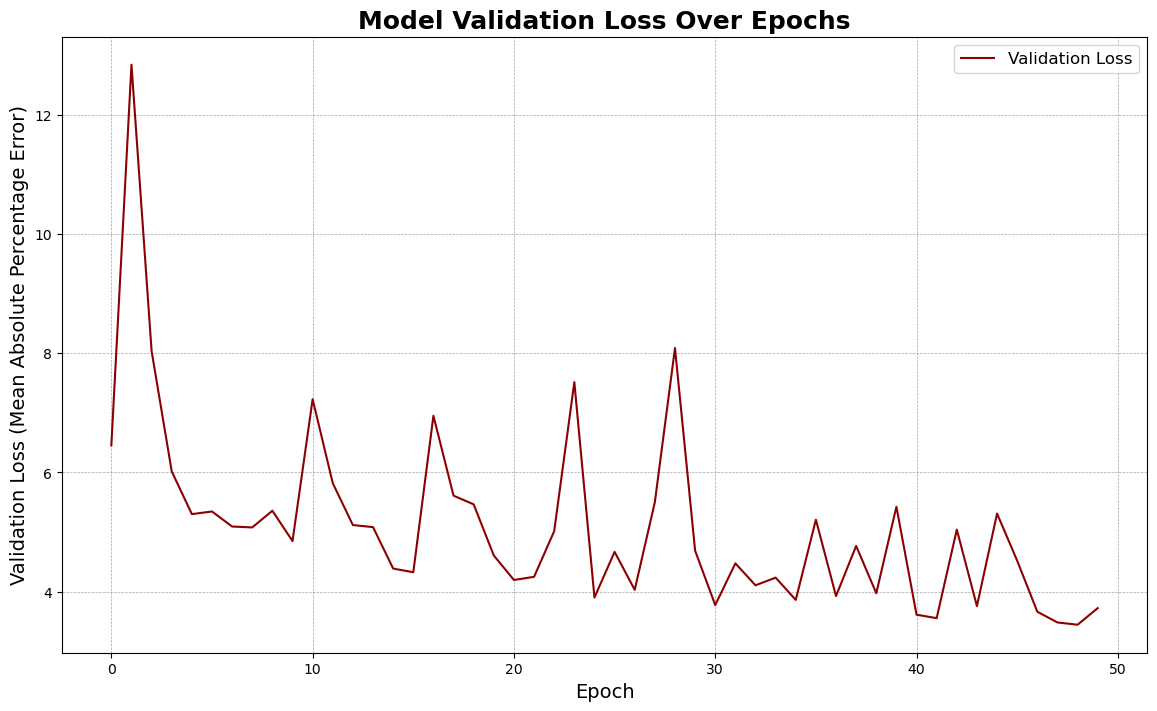

In [67]:
plot_validation_loss(history8)

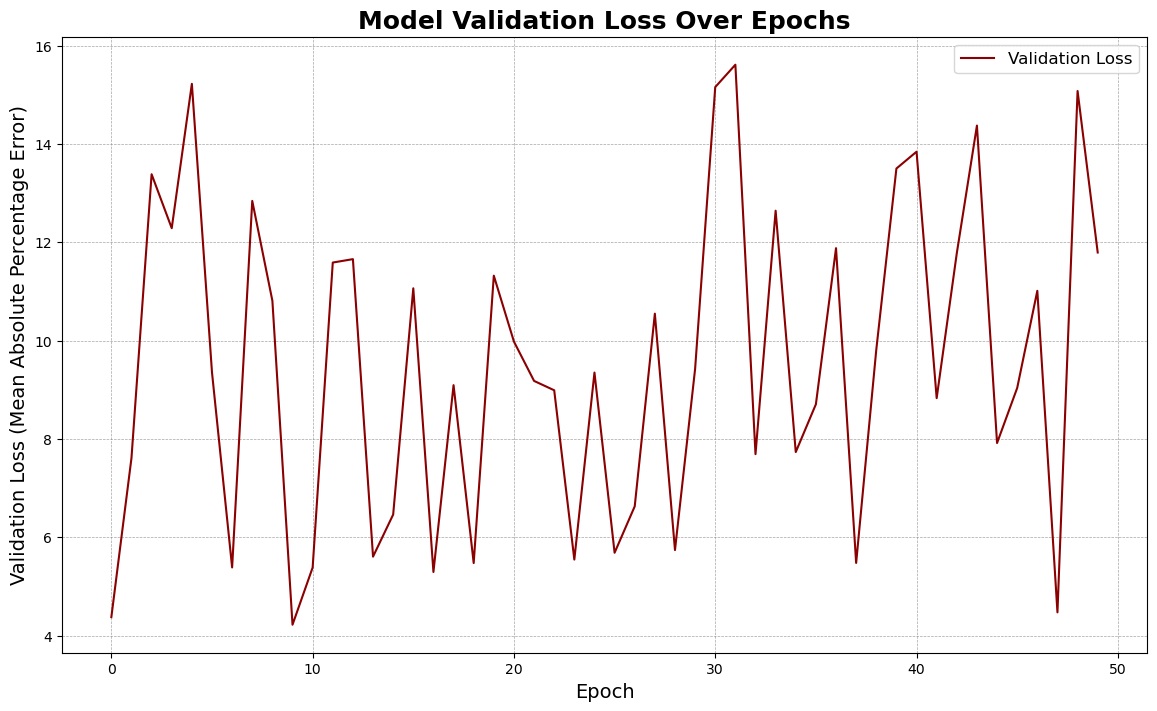

In [68]:
plot_validation_loss(history9)

In [35]:
import matplotlib.pyplot as plt

def plot_training_loss(history, figsize=(14, 8), title='Model Training Loss Over Epochs'):
    plt.figure(figsize=figsize)
    plt.plot(history.history['loss'], color='darkred', linestyle='-', linewidth=1.5, label='Training Loss')
    plt.title(title, fontsize=18, fontweight='bold')
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Training Loss (Mean Absolute Percentage Error)', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.show()


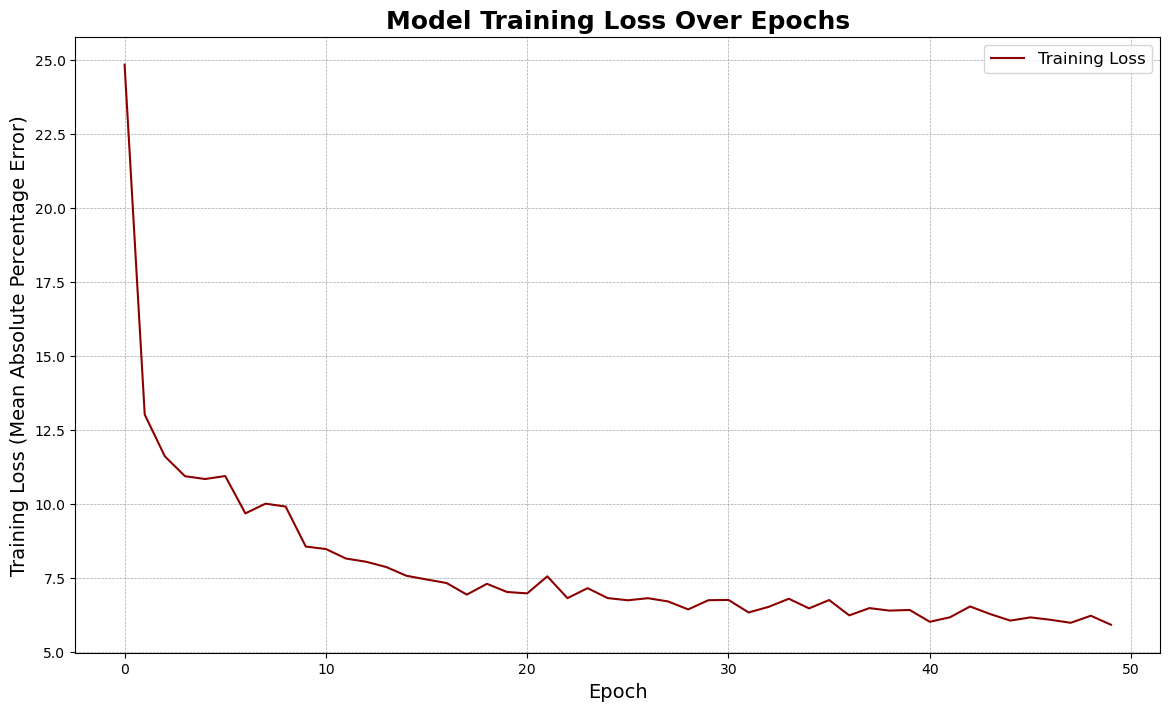

In [36]:
plot_training_loss(history1)


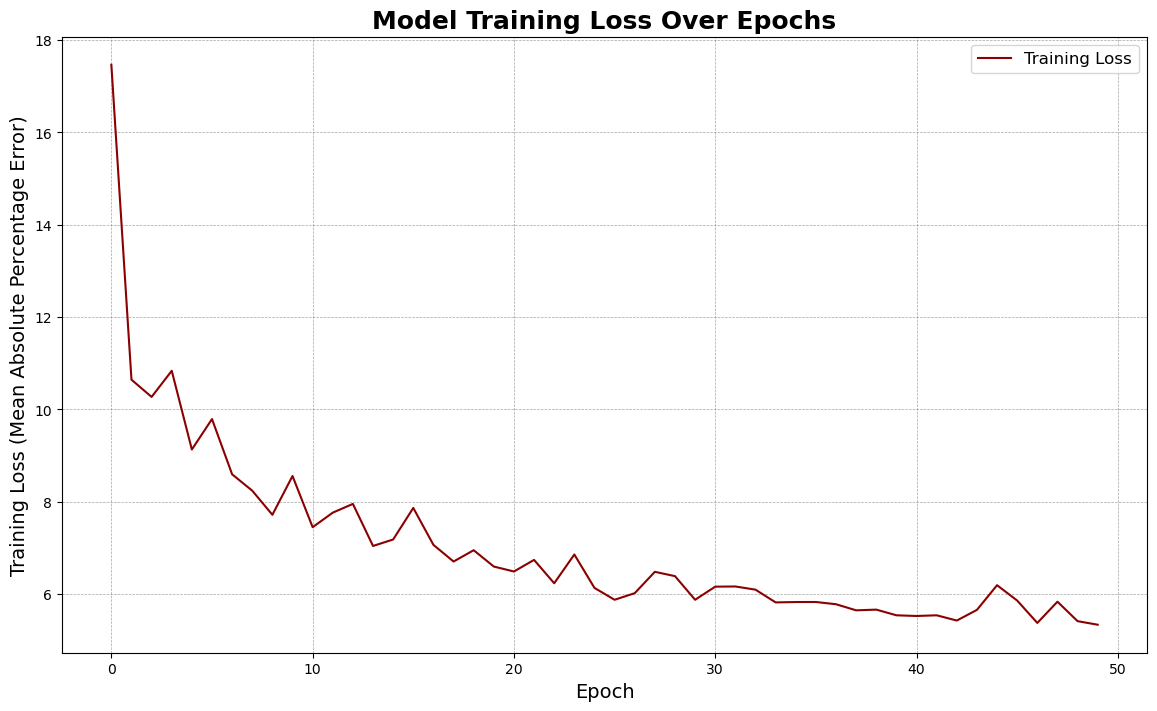

In [37]:
plot_training_loss(history2)


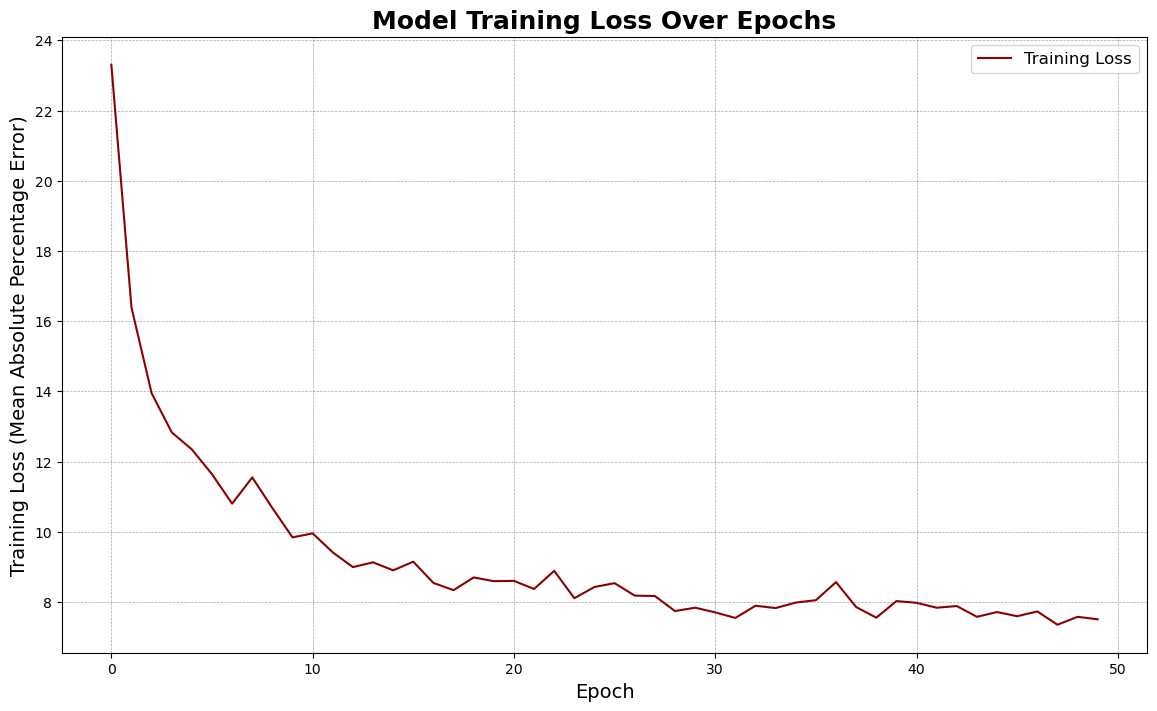

In [38]:
plot_training_loss(history3)


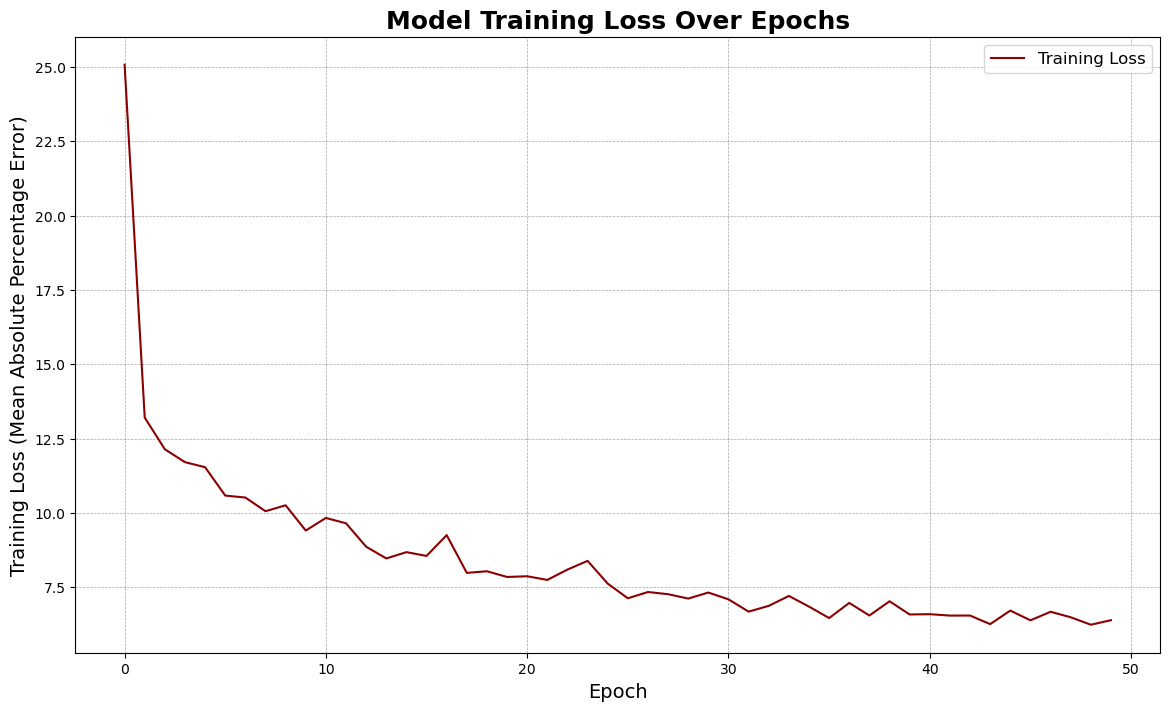

In [39]:
plot_training_loss(history4)


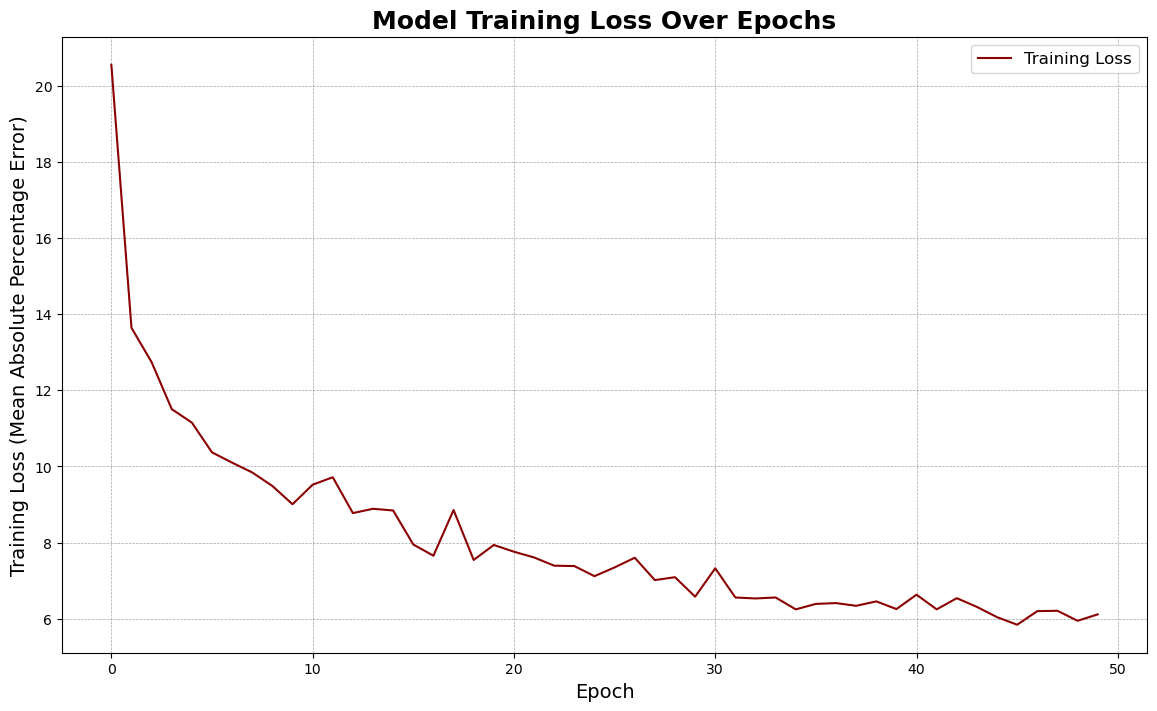

In [40]:
plot_training_loss(history5)

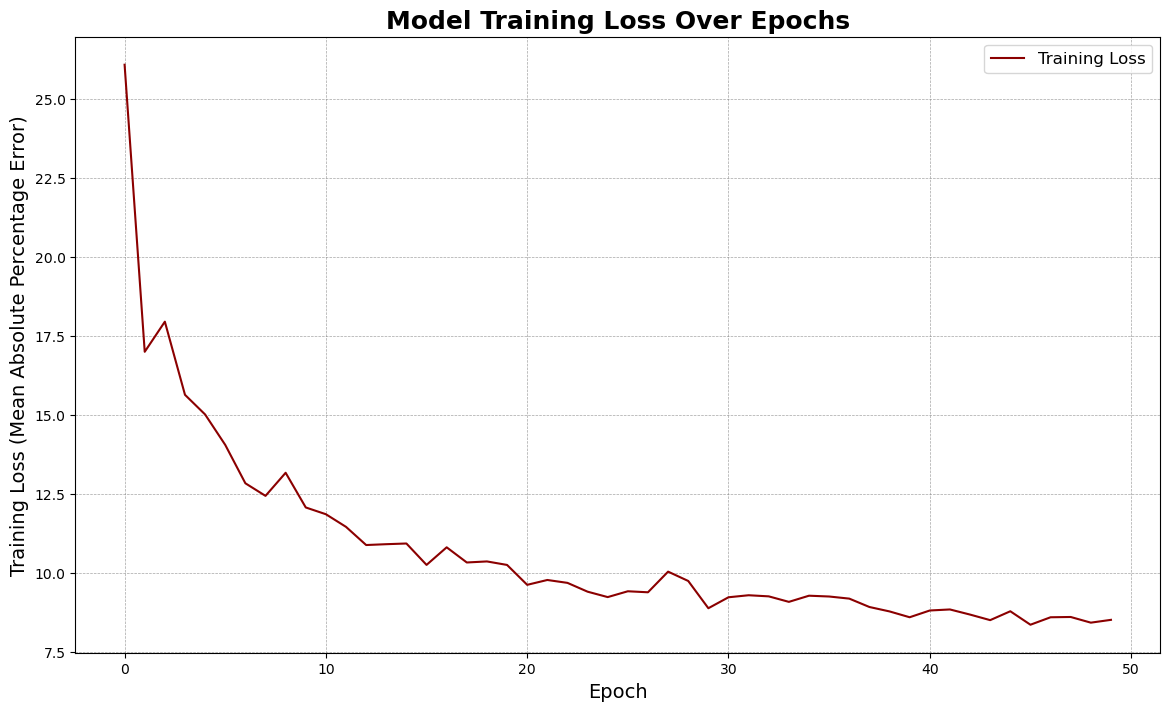

In [41]:
plot_training_loss(history6)

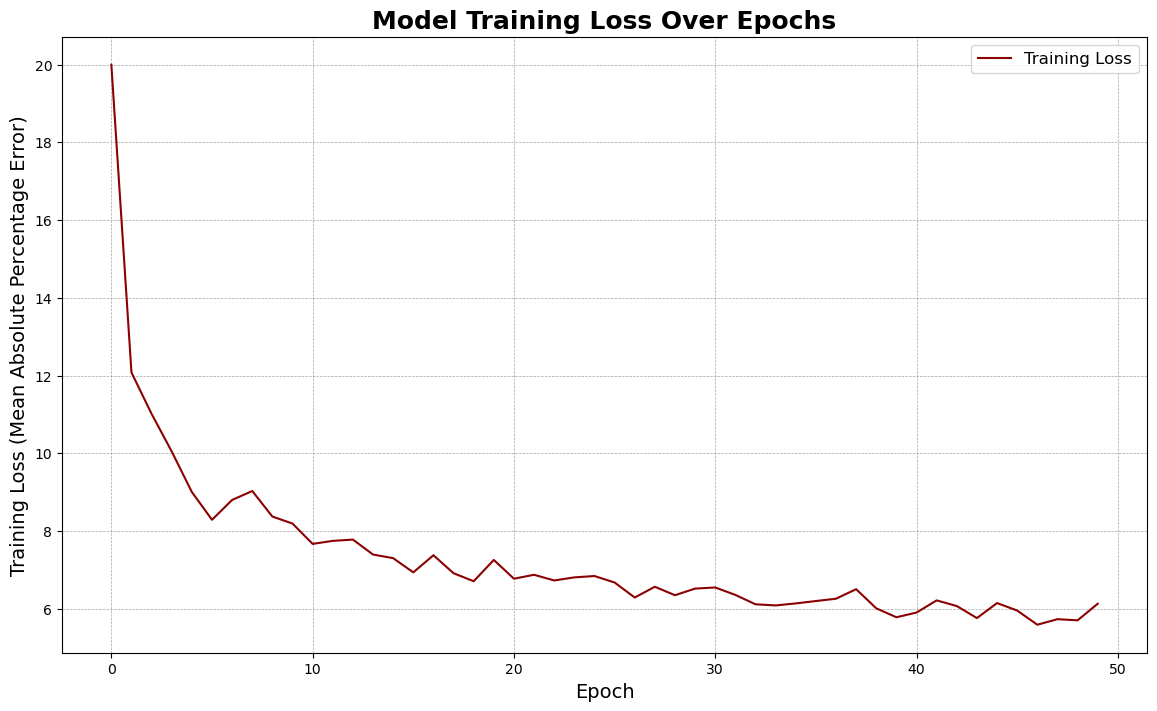

In [42]:
plot_training_loss(history7)

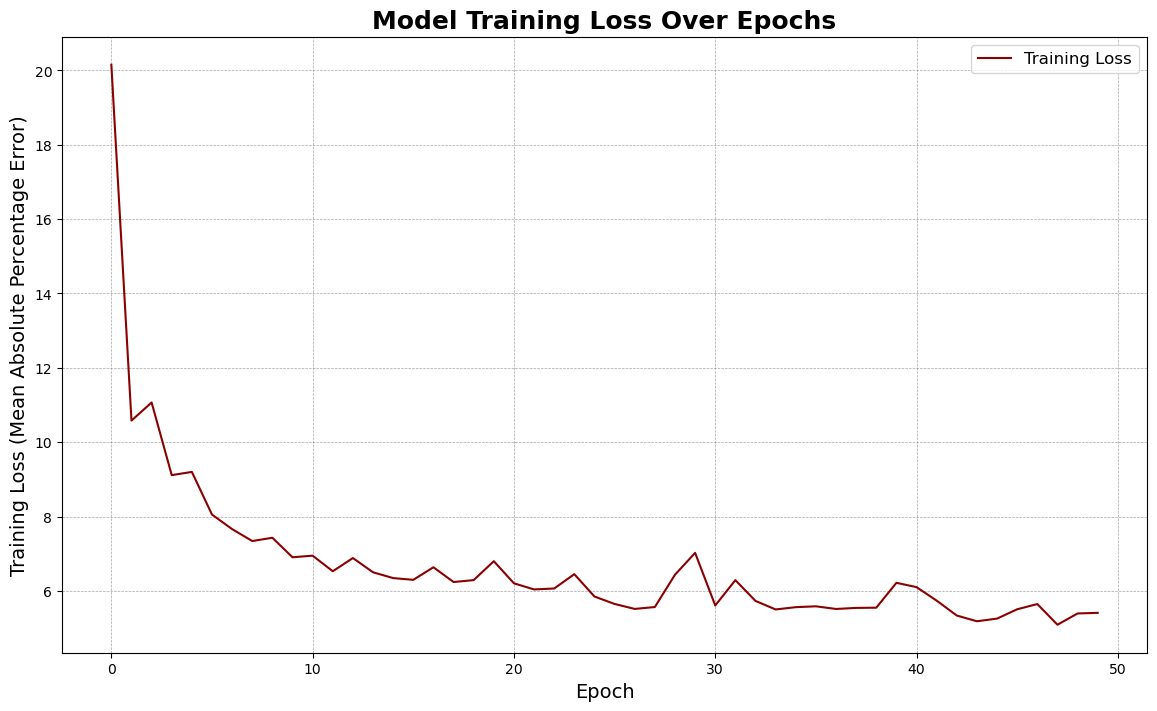

In [60]:
plot_training_loss(history8)

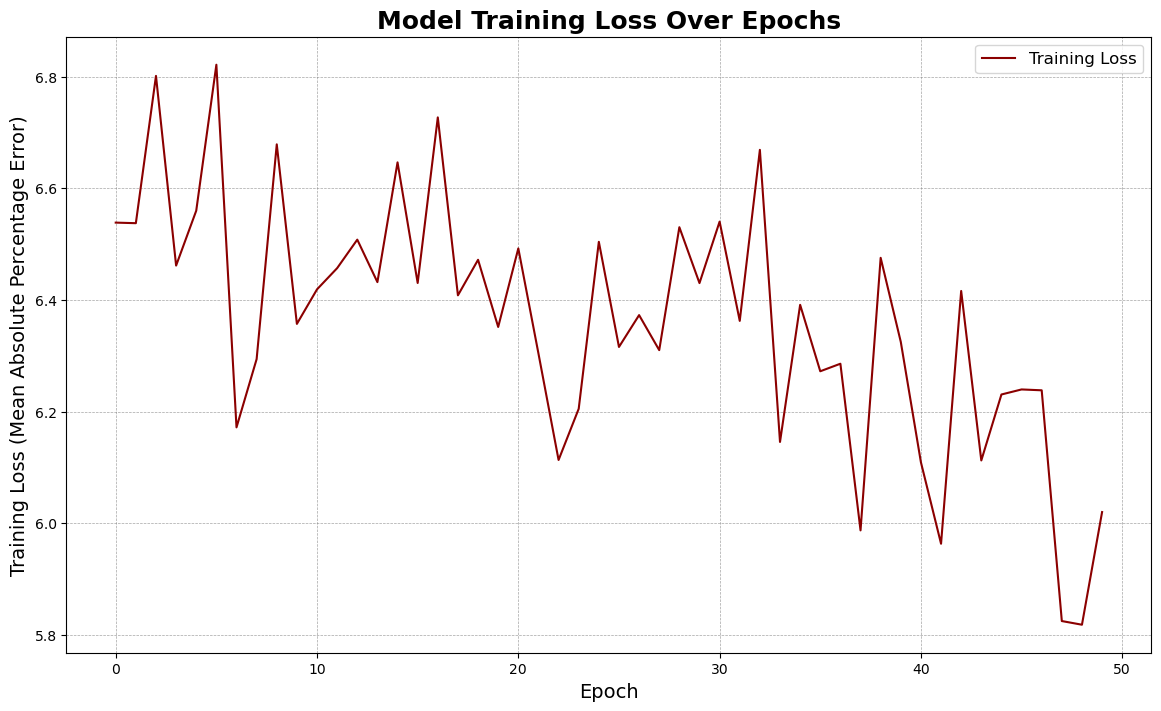

In [65]:
plot_training_loss(history9)

In [45]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

def plot_price_prediction_with_zoom(actual_prices, predicted_prices, start, end, title='Bitcoin Close Price Prediction vs Actual Prices'):
   
    # Obliczenie minimalnych i maksymalnych wartości dla zaznaczonego zakresu
    min_price = min(min(actual_prices[start:end]), min(predicted_prices[start:end]))
    max_price = max(max(actual_prices[start:end]), max(predicted_prices[start:end]))

    # Tworzenie głównego wykresu
    fig, ax = plt.subplots(figsize=(14, 8))

    # Główny wykres rzeczywistych i przewidywanych cen
    ax.plot(actual_prices, color='blue', linestyle='-', linewidth=1.5, label='Actual Close Price')
    ax.plot(predicted_prices, color='red', linestyle='--', linewidth=1.5, label='Predicted Close Price')

    # Dodanie prostokąta zaznaczającego zakres
    rect = patches.Rectangle((start, min_price), 
                             end - start, 
                             max_price - min_price, 
                             linewidth=1.5, edgecolor='black', facecolor='none', linestyle='--')
    ax.add_patch(rect)

    # Tytuł i etykiety osi
    ax.set_title(title, fontsize=16, fontweight='bold')
    ax.set_xlabel('Time (Days)', fontsize=14)
    ax.set_ylabel('Price (USD)', fontsize=14)
    ax.legend(fontsize=12)
    ax.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)

    # Tworzenie mniejszego wykresu (powiększony wycinek) w prawym górnym rogu
    ax_inset = fig.add_axes([0.6, 0.55, 0.3, 0.3])
    ax_inset.plot(range(start, end), actual_prices[start:end], color='blue', linestyle='-', linewidth=1.5)
    ax_inset.plot(range(start, end), predicted_prices[start:end], color='red', linestyle='--', linewidth=1.5)
    ax_inset.set_title('Zoomed-in', fontsize=10)
    ax_inset.set_xlabel('Time', fontsize=8)
    ax_inset.set_ylabel('Price', fontsize=8)
    ax_inset.tick_params(axis='both', which='major', labelsize=8)
    ax_inset.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)

    plt.show()


In [46]:
# Funkcja do prognozowania w interwałach
def predict_in_intervals(model, X_test, interval_size=1000):
    predictions = []
    for start in range(0, len(X_test), interval_size):
        end = min(start + interval_size, len(X_test))
        predictions_interval = model.predict(X_test[start:end])
        predictions.append(predictions_interval)
    return np.concatenate(predictions)

In [47]:
def predict_and_plot_with_zoom(model, X_test, y_test, scaler, start=50, end=80):
    # Prognozowanie na interwałach
    predicted_prices_intervals = predict_in_intervals(model, X_test, interval_size=1000)
 # Prognoza i skalowanie na oryginalną skalę
    predicted_prices = model.predict(X_test)
    
    # Przywrócenie skali i przygotowanie do wykresu
    predicted_prices_intervals = np.concatenate([predicted_prices_intervals] * 5, axis=1)
    predicted_prices_intervals = scaler.inverse_transform(predicted_prices_intervals)
    actual_prices = scaler.inverse_transform(np.concatenate([y_test.reshape(-1, 1)] * 5, axis=1))[:, 3]
    predicted_close_prices = predicted_prices_intervals[:, 3]

   
    
    # Rysowanie wykresu z powiększonym wycinkiem
    plot_price_prediction_with_zoom(actual_prices, predicted_close_prices, start, end)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


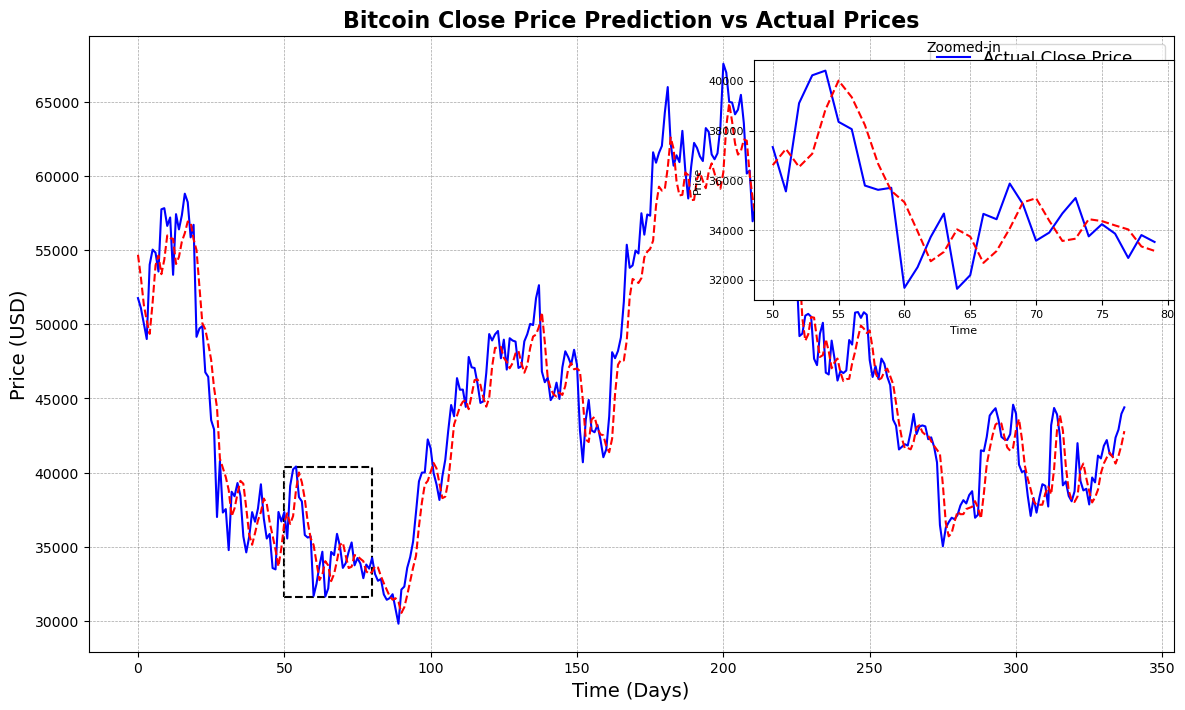

In [48]:
predict_and_plot_with_zoom(model_lstm_1, X_test, y_test, scaler, start=50, end=80)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


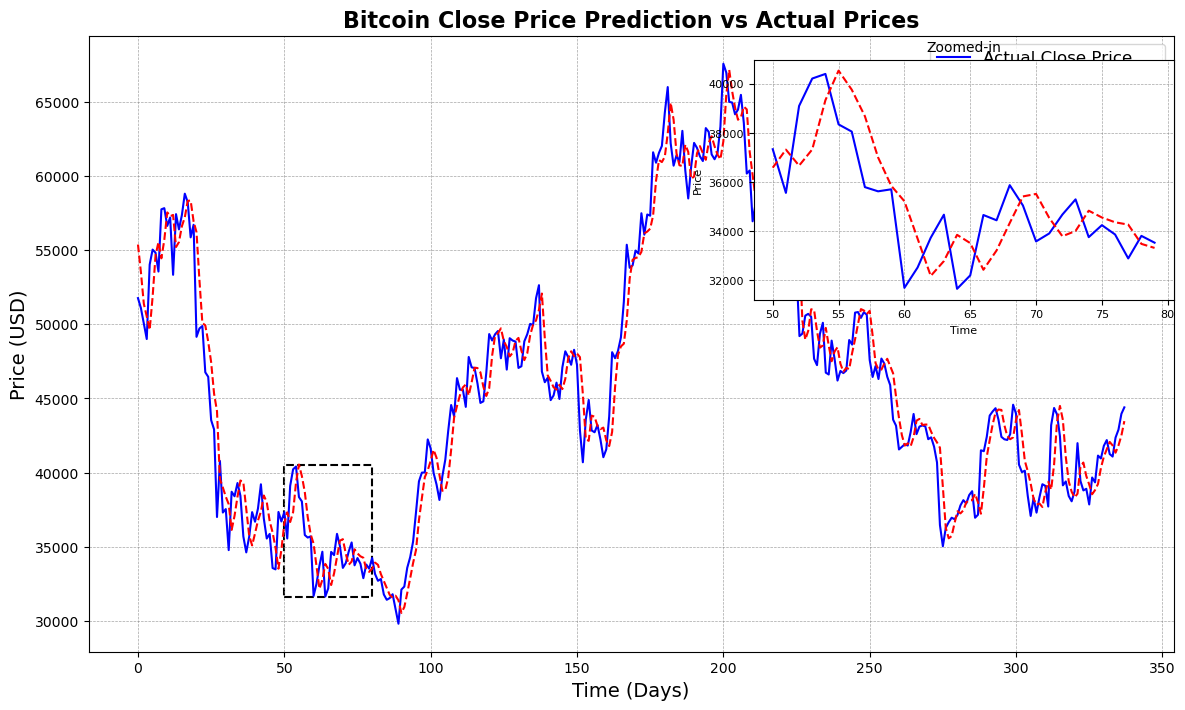

In [49]:
predict_and_plot_with_zoom(model_lstm_2, X_test, y_test, scaler, start=50, end=80)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


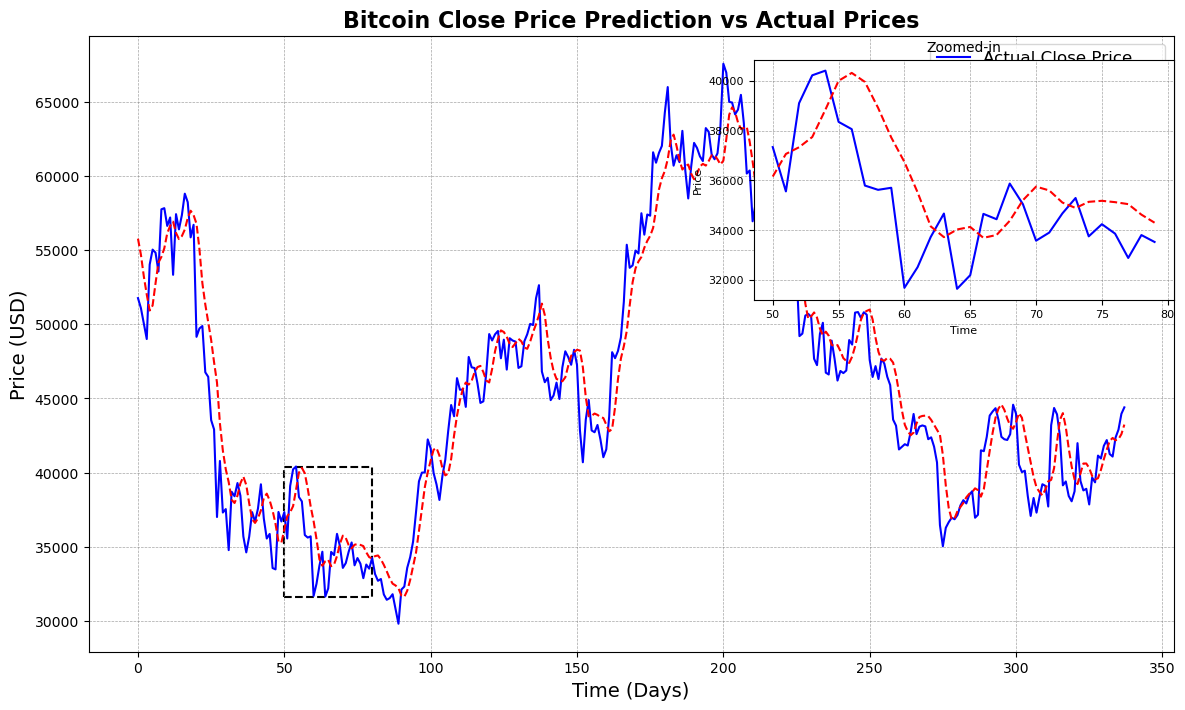

In [50]:
predict_and_plot_with_zoom(model_lstm_3, X_test, y_test, scaler, start=50, end=80)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


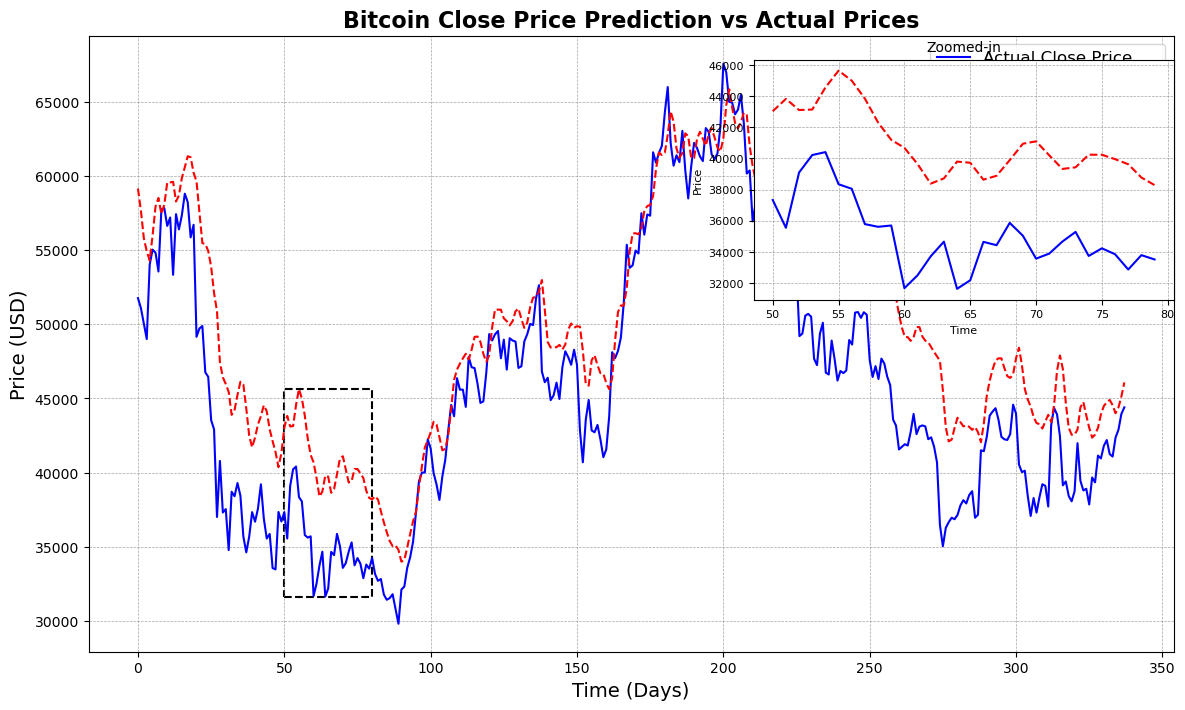

In [51]:
predict_and_plot_with_zoom(model_lstm_1_bidirectional, X_test, y_test, scaler, start=50, end=80)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


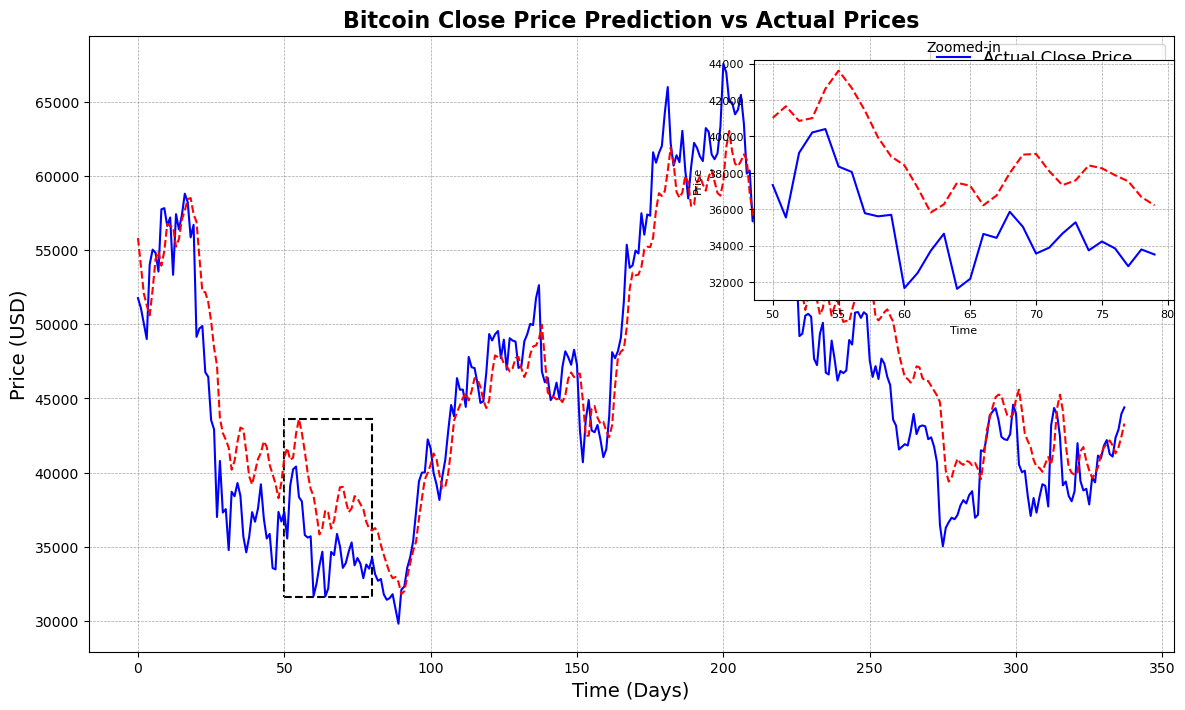

In [52]:
predict_and_plot_with_zoom(model_lstm_2_bidirectional, X_test, y_test, scaler, start=50, end=80)

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


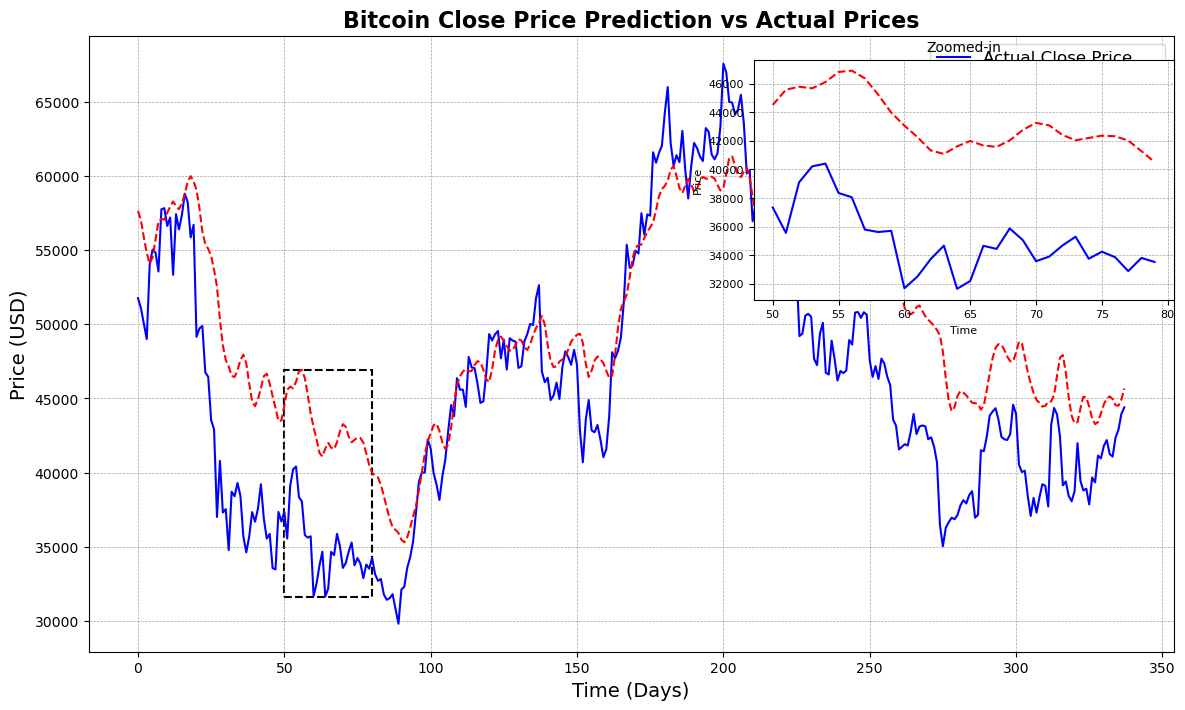

In [53]:
predict_and_plot_with_zoom(model_lstm_3_bidirectional, X_test, y_test, scaler, start=50, end=80)

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


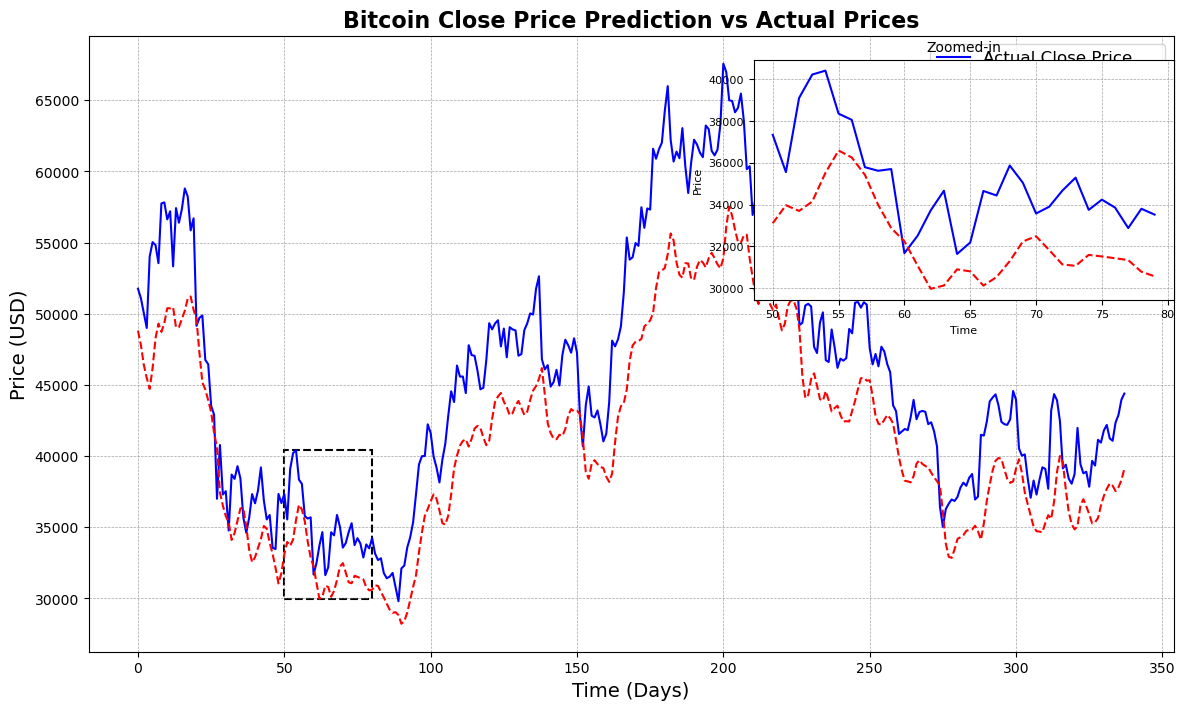

In [54]:
predict_and_plot_with_zoom(model_lstm_1_dense, X_test, y_test, scaler, start=50, end=80)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


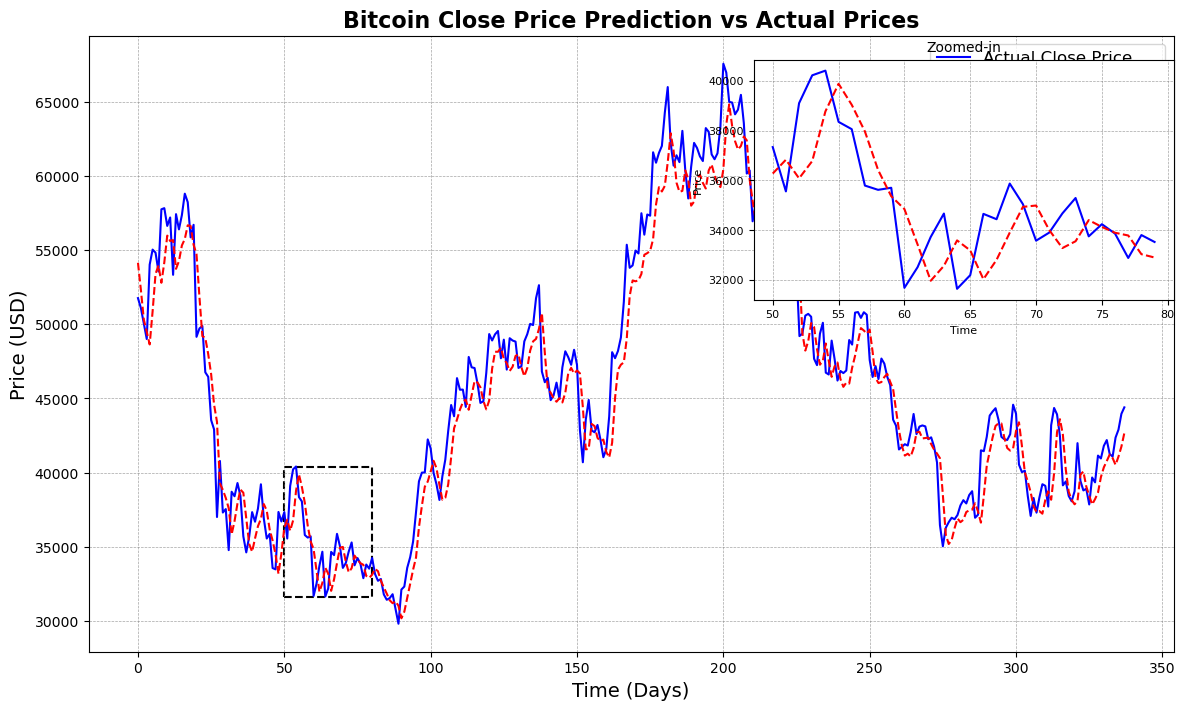

In [63]:
predict_and_plot_with_zoom(model_lstm_2_dense, X_test, y_test, scaler, start=50, end=80)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


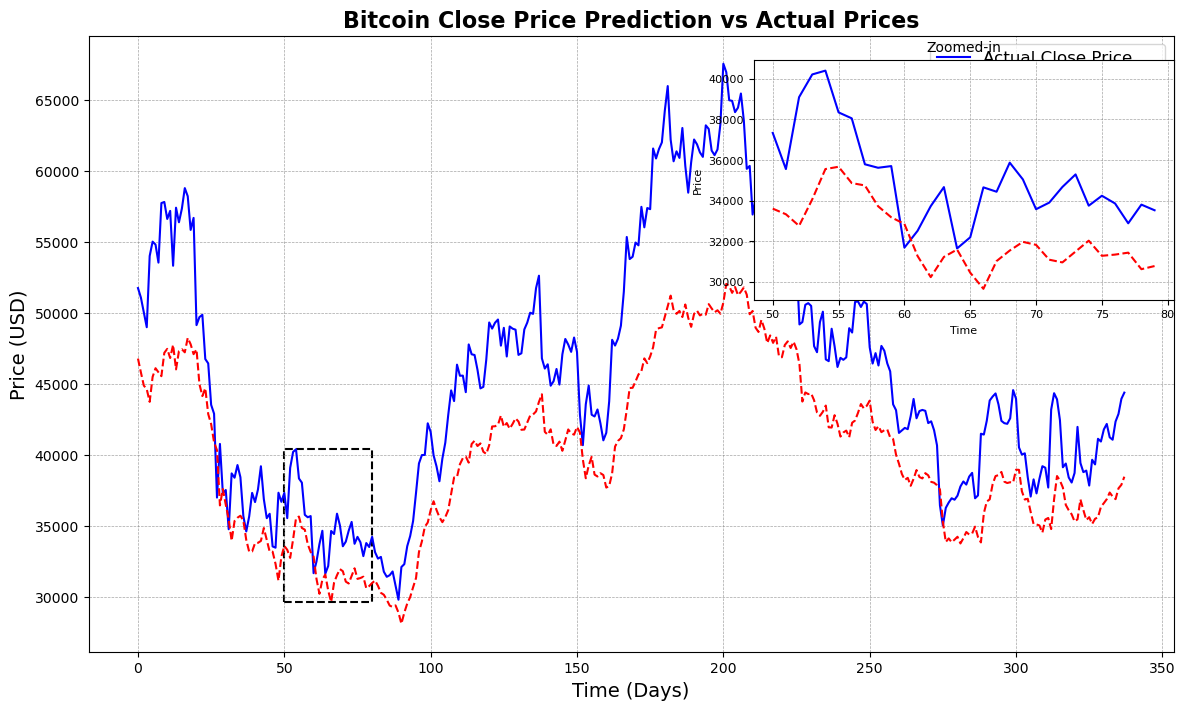

In [64]:
predict_and_plot_with_zoom(model_lstm_3_dense, X_test, y_test, scaler, start=50, end=80)

In [ ]:
new_data = pd.read_csv(r'bitcoin_price_Training - Training.csv')
new_data['Volume'] = new_data['Volume'].astype(str).str.replace(',', '').replace('-', '0').astype(float)
for col in ['Open', 'High', 'Low', 'Close']:
    new_data[col] = pd.to_numeric(new_data[col], errors='coerce')
new_data.dropna(inplace=True)
# Step 2: Select the same features and scale
new_data = new_data[features]  # Using the same 'features' list as before
scaled_new_data = scaler.transform(new_data)  # Use the same scaler from training

X_new, y_new = create_sequences(scaled_new_data, SEQ_LENGTH)
X_new = X_new.reshape((X_new.shape[0], X_new.shape[1], len(features)))

predict_and_plot_with_zoom(model_lstm_1, X_new, y_new, scaler, start=50, end=80)


FileNotFoundError: [Errno 2] No such file or directory: 'bitcoin_price_Training - Training.csv'

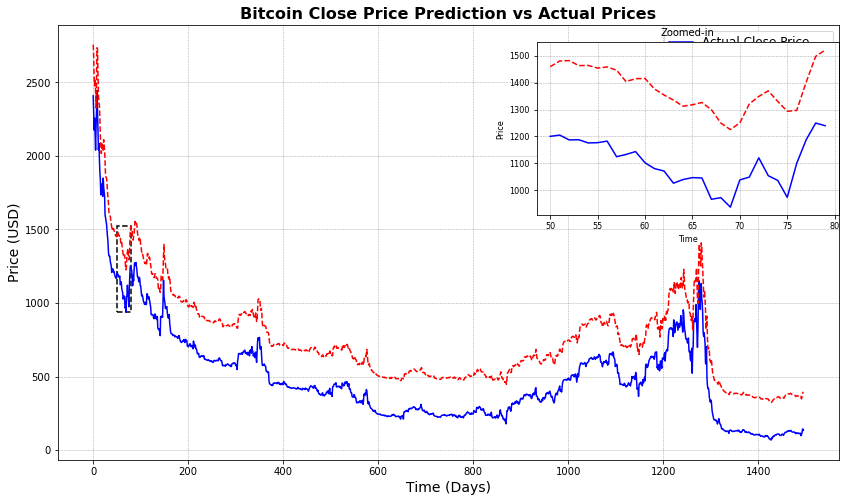

In [ ]:
new_data = pd.read_csv(r'bitcoin_price_Training - Training.csv')
new_data['Volume'] = new_data['Volume'].astype(str).str.replace(',', '').replace('-', '0').astype(float)
for col in ['Open', 'High', 'Low', 'Close']:
    new_data[col] = pd.to_numeric(new_data[col], errors='coerce')
new_data.dropna(inplace=True)
# Step 2: Select the same features and scale
new_data = new_data[features]  # Using the same 'features' list as before
scaled_new_data = scaler.transform(new_data)  # Use the same scaler from training

X_new, y_new = create_sequences(scaled_new_data, SEQ_LENGTH)
X_new = X_new.reshape((X_new.shape[0], X_new.shape[1], len(features)))

predict_and_plot_with_zoom(model_lstm_2, X_new, y_new, scaler, start=50, end=80)


In [ ]:
predict_and_plot_with_zoom(model_lstm_3, X_new, y_new, scaler, start=50, end=80)

In [ ]:
predict_and_plot_with_zoom(model_lstm_1_bidirectional, X_new, y_new, scaler, start=50, end=80)

In [ ]:
predict_and_plot_with_zoom(model_lstm_2_bidirectional, X_new, y_new, scaler, start=50, end=80)

In [ ]:
predict_and_plot_with_zoom(model_lstm_3_bidirectional, X_new, y_new, scaler, start=50, end=80)

In [ ]:
predict_and_plot_with_zoom(model_lstm_1_dense, X_new, y_new, scaler, start=50, end=80)

In [ ]:
predict_and_plot_with_zoom(model_lstm_2_dense, X_new, y_new, scaler, start=50, end=80)

In [ ]:
predict_and_plot_with_zoom(model_lstm_3_dense, X_new, y_new, scaler, start=50, end=80)

In [ ]:
historyX = model_lstm_1.fit(X_train, y_train, epochs=1, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10000
43/43 [==============================] - 1s 15ms/step - loss: 5.1617 - val_loss: 10.9114
Epoch 2/10000
43/43 [==============================] - 0s 11ms/step - loss: 4.8677 - val_loss: 10.0387
Epoch 3/10000
43/43 [==============================] - 0s 12ms/step - loss: 4.8514 - val_loss: 9.3916
Epoch 4/10000
43/43 [==============================] - 0s 11ms/step - loss: 4.7021 - val_loss: 9.9547
Epoch 5/10000
43/43 [==============================] - 0s 11ms/step - loss: 4.6865 - val_loss: 11.2556
Epoch 6/10000
43/43 [==============================] - 1s 12ms/step - loss: 4.8145 - val_loss: 15.6955
Epoch 7/10000
43/43 [==============================] - 0s 12ms/step - loss: 4.6634 - val_loss: 12.2741
Epoch 8/10000
43/43 [==============================] - 1s 12ms/step - loss: 4.8355 - val_loss: 10.6160
Epoch 9/10000
43/43 [==============================] - 1s 13ms/step - loss: 4.8675 - val_loss: 9.6302
Epoch 10/10000
43/43 [==============================] - 1s 12ms/step - loss:

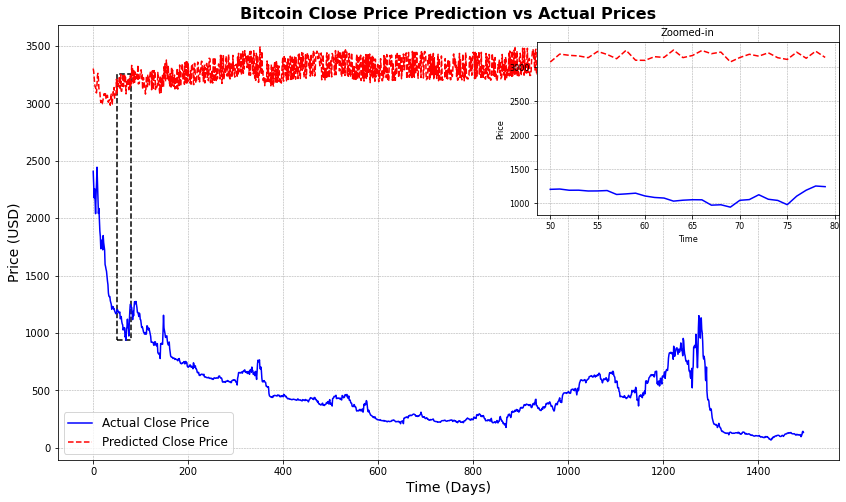

In [ ]:
new_data = pd.read_csv(r'bitcoin_price_Training - Training.csv')
new_data['Volume'] = new_data['Volume'].astype(str).str.replace(',', '').replace('-', '0').astype(float)
for col in ['Open', 'High', 'Low', 'Close']:
    new_data[col] = pd.to_numeric(new_data[col], errors='coerce')
new_data.dropna(inplace=True)
# Step 2: Select the same features and scale
new_data = new_data[features]  # Using the same 'features' list as before
scaled_new_data = scaler.transform(new_data)  # Use the same scaler from training

X_new, y_new = create_sequences(scaled_new_data, SEQ_LENGTH)
X_new = X_new.reshape((X_new.shape[0], X_new.shape[1], len(features)))

predict_and_plot_with_zoom(model_lstm_1before, X_new, y_new, scaler, start=50, end=80)


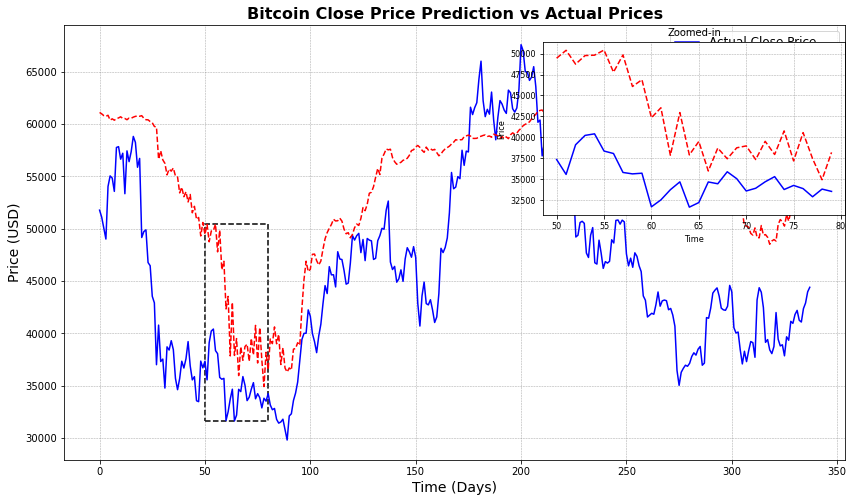

In [ ]:
predict_and_plot_with_zoom(model_lstm_1before, X_test, y_test, scaler, start=50, end=80)


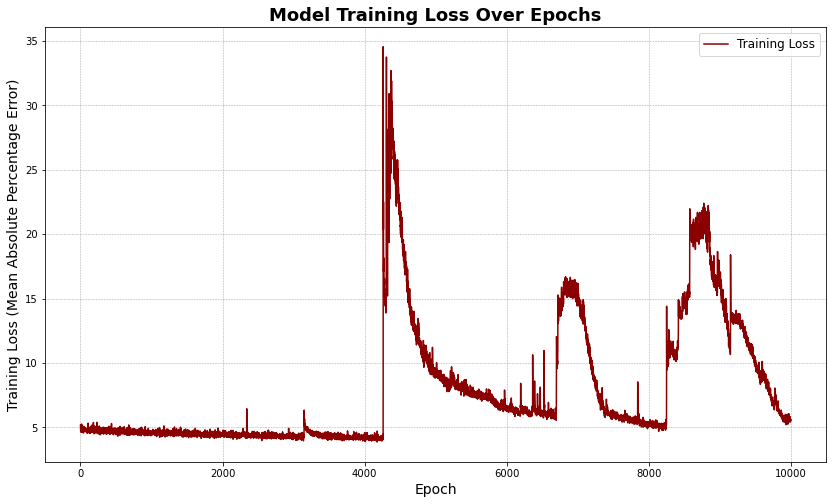

In [ ]:
plot_training_loss(historyX)